# Aufgabe 2 – Suchstrategien

In [1]:
#Importiern der benötigten Bibliotheken und des Datensatzes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D 

## 2.1 Datensichtung

In [2]:
#Einlesen der Episode 0 der Suchstrategie Nummer 2
episode_path = 'data_v2/data_search_strategy/strategy_2/episode_0.csv'
#Semikolon als Trennzeichen verwenden!
df = pd.read_csv(episode_path, sep=';',decimal=",")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   step                     537 non-null    int64  
 1   ros_timestamp            537 non-null    float64
 2   ft_wrench_fx             489 non-null    float64
 3   ft_wrench_fy             507 non-null    float64
 4   ft_wrench_fz             511 non-null    float64
 5   ft_wrench_tx             500 non-null    float64
 6   ft_wrench_ty             482 non-null    float64
 7   ft_wrench_tz             492 non-null    float64
 8   current_absolute_pose_x  537 non-null    float64
 9   current_absolute_pose_y  537 non-null    float64
 10  current_absolute_pose_z  537 non-null    float64
 11  current_twist_vx         498 non-null    float64
 12  current_twist_vy         501 non-null    float64
 13  current_twist_vz         501 non-null    float64
 14  current_twist_wx         5

In [3]:
#Druchschnittliche Abtastzeit & Anzahl der Schritte & Dauer in Millisekunden

#print(df['ros_timestamp'].head())

print(f'Druchschnittliche Abtastzeit in ms: {(df["ros_timestamp"].diff().mean())*1000:.2f}')
print(f'Anzahl der Schritte: {len(df)}')
print(f'Dauer in ms: {(df["ros_timestamp"].iloc[-1] - df["ros_timestamp"].iloc[0])*1000:.2f}')

Druchschnittliche Abtastzeit in ms: 33.30
Anzahl der Schritte: 537
Dauer in ms: 17849.70


In [4]:
#Fehlende Werte zählen und auflisten
missing_values = df.isnull().sum()

print('Anzahl der fehlenden Werte pro Spalte:', missing_values[missing_values > 0])
print('Alle Fehlenden Werte:', missing_values.sum())


Anzahl der fehlenden Werte pro Spalte: ft_wrench_fx        48
ft_wrench_fy        30
ft_wrench_fz        26
ft_wrench_tx        37
ft_wrench_ty        55
ft_wrench_tz        45
current_twist_vx    39
current_twist_vy    36
current_twist_vz    36
current_twist_wx    24
current_twist_wy    18
current_twist_wz    25
action_f_x           1
action_f_y           2
action_t_z           1
dtype: int64
Alle Fehlenden Werte: 423


### 2.1.4 Fehlende Werte auffüllen
Fehlende Werte auffüllen mit Lineare Interpolation, Sensordaten vor und nach dem fehlenden Wert werden verwendet, um den fehlenden Wert zu interpolieren. Sehr gut für Zeitreihen, da sie die Kontinuität der Daten bewahrt. Lineare Interpolation ist besser als Vorwärts- oder Rückwärtsfüllung, da sie die Trends in den Daten berücksichtigt und nicht einfach den letzten bekannten Wert wiederholt.

In [5]:
#Fehlender Werte auffüllen
df_filled = df.interpolate(method='linear')
print('Anzahl der fehlenden Werte nach Auffüllen:',df_filled.isnull().sum().sum())

#Immer noch fehlende Werte auffüllen mit Vorwärtsfüllung
df_filled = df_filled.ffill()
print('Anzahl der fehlenden Werte nach Vorwärtsfüllung:',df_filled.isnull().sum().sum())

#Fehlender Werte ist in der ersten Zeile auffüllen mit Rückwärtsfüllung
df_filled = df_filled.bfill()
print('Anzahl der fehlenden Werte nach Rückwärtsfüllung:',df_filled.isnull().sum().sum())

Anzahl der fehlenden Werte nach Auffüllen: 1
Anzahl der fehlenden Werte nach Vorwärtsfüllung: 1
Anzahl der fehlenden Werte nach Rückwärtsfüllung: 0


In [6]:
gamma = 0.999 #Diskontierungsfaktor, der die Gewichtung zukünftiger Belohnungen steuert. 

t = np.arange(len(df_filled)) #Zeitschritt oder Schrittindex, der die Position jedes Eintrags in der Zeitreihe darstellt.

value_v_ep0 = (gamma ** t * df_filled['reward'].values).sum()
print(f'Der Wert der Episode 0 ist: {value_v_ep0:.4f}')



Der Wert der Episode 0 ist: 0.5849


### 2.1.6 Diskontierungsfaktor gamma
Der Discount-Faktor gamma = 0.999 gewichtet zukünftige Rewards geringer als sofortige. Da der Reward immer 1 am Ende einer erfolgreichen Episode ist, erhält eine kürzere Episode automatisch einen höheren Value, weil der Reward früher eintrifft und weniger diskontiert wird. Damit bevorzugt die Value-Funktion schnellere Einsteckvorgänge, ohne die Reward-Funktion ändern zu müssen.

## 2.2 Visualisierung der Daten

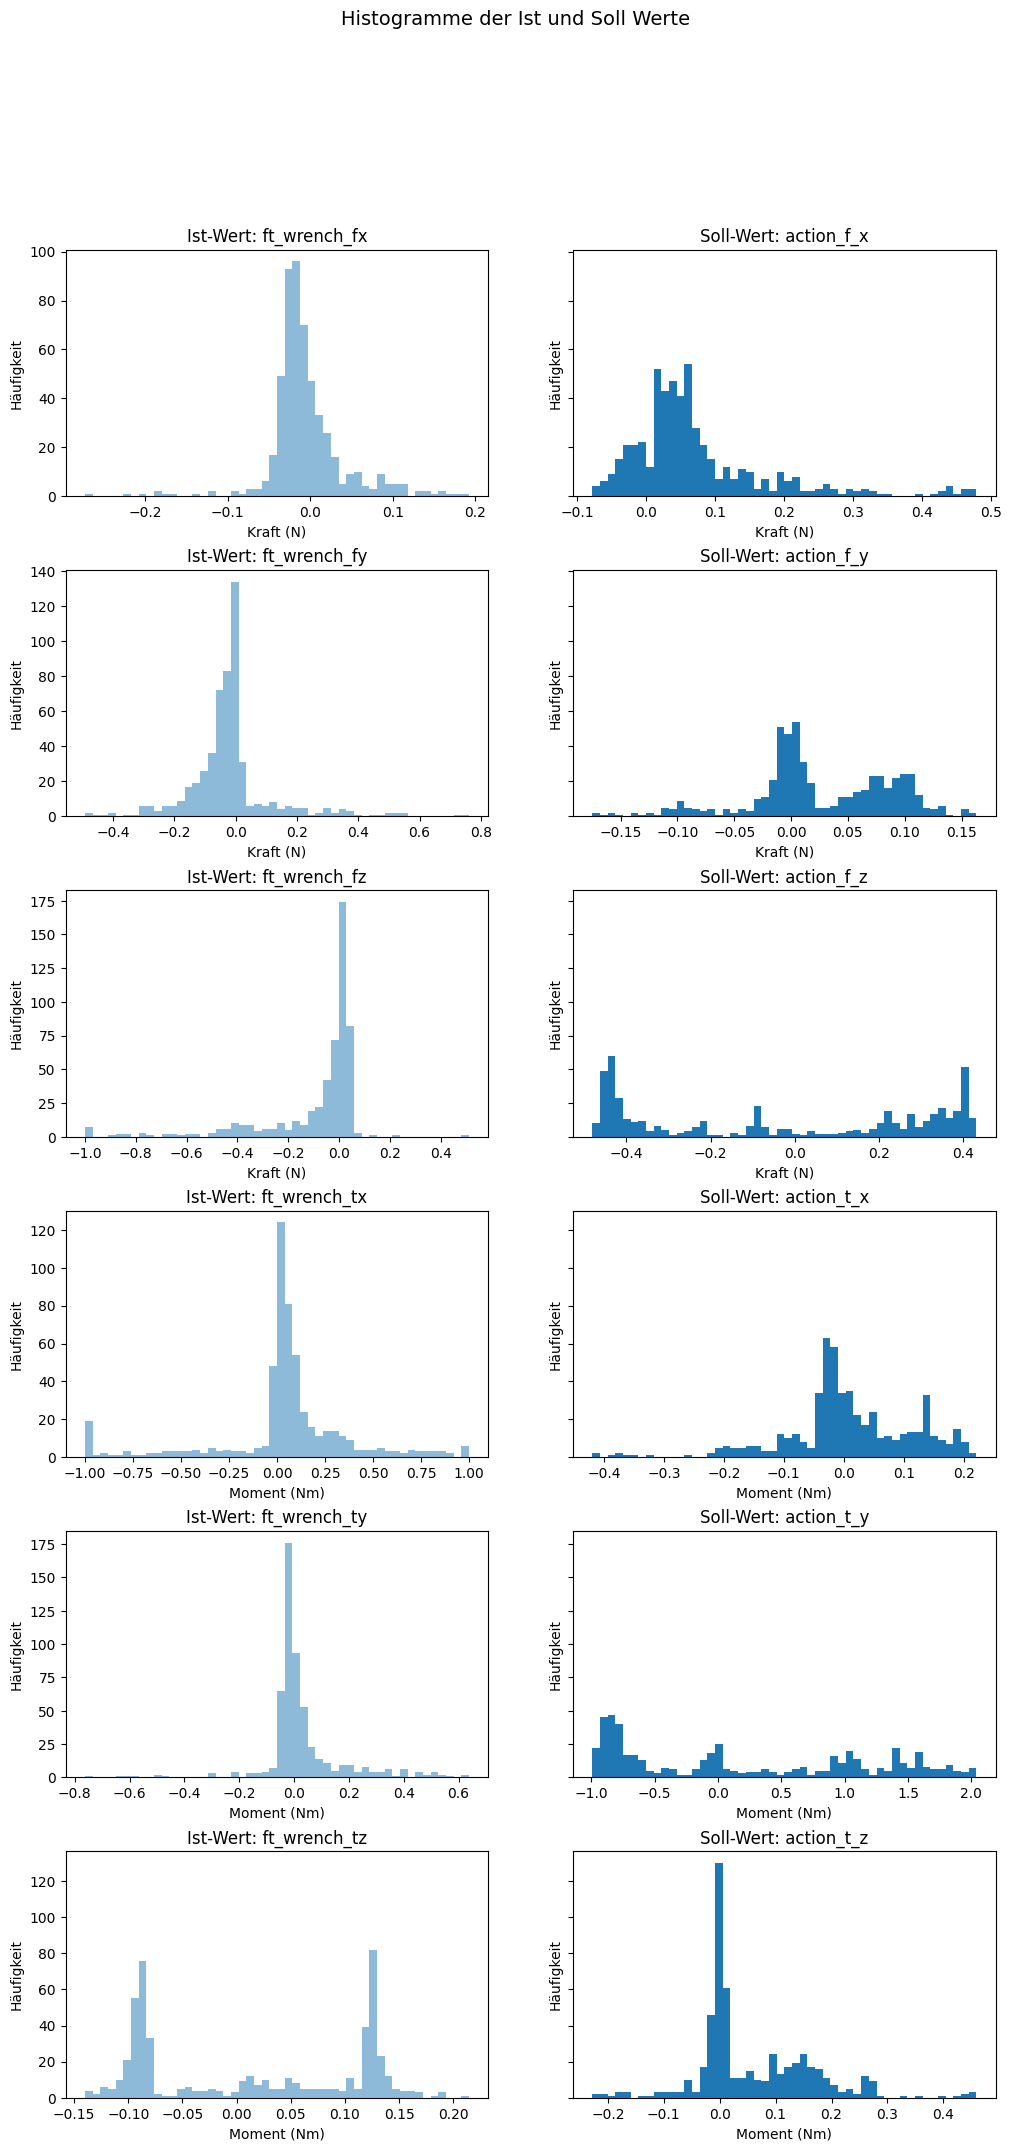

In [7]:
#Visualisierung der Daten
fig, axes = plt.subplots(6, 2, sharey='row', figsize=(12, 24))
plt.subplots_adjust(hspace=0.3)
fig.suptitle('Histogramme der Ist und Soll Werte', fontsize=14)

#Liste der Sensorwerte
ist_colums = ['ft_wrench_fx', 'ft_wrench_fy', 'ft_wrench_fz', 'ft_wrench_tx', 'ft_wrench_ty', 'ft_wrench_tz']
soll_colums = ['action_f_x', 'action_f_y', 'action_f_z', 'action_t_x', 'action_t_y', 'action_t_z']
x_labels = ['Kraft (N)', 'Kraft (N)', 'Kraft (N)', 'Moment (Nm)', 'Moment (Nm)', 'Moment (Nm)']

#Schleife über die Sensorwerte und Erstellen von Histogrammen
for i, (ist_col, soll_col, x_label) in enumerate(zip(ist_colums, soll_colums, x_labels)):
    axes[i, 0].hist(df_filled[ist_col], bins=50, alpha=0.5)
    axes[i, 1].hist(df_filled[soll_col], bins=50, alpha=1)
    axes[i, 0].set_title(f'Ist-Wert: {ist_col}')
    axes[i, 1].set_title(f'Soll-Wert: {soll_col}')
    axes[i, 0].set_xlabel(x_labels[i])
    axes[i, 1].set_xlabel(x_labels[i])
    axes[i, 0].set_ylabel('Häufigkeit')
    axes[i, 1].set_ylabel('Häufigkeit')
plt.show()

### 2.2.2 Was fällt dir auf? Welche Abweichungen zwischen Soll und Ist-Werten gitbt es?

*Auffälligkeiten:*
- Kräfte: Ist Werte sind enger als die Soll-Werte, der Roboter folgt den Soll Kräften nicht exakt.
- Momente: Ähnlich wie bei den Kräften, die Ist Werte sind enger als die Soll-Werte. Mit Ausnahme von Moment in Z, hier gibt es eine größere Abweichung, die Ist Werte sind weiter von den Soll-Werten entfernt.

*Mögliche Ursachen:*
- Regelungsungenauigkeiten: Die Regelung des Roboters könnten nicht optimal eingestellt sein, was zu einer ungenauen Nachverfolgung der Soll-Werte führt
- Mechanische Einschränkungen: Es könnte mechanische Einschränkungen(Reibung, Spiel) oder Verzögerungen im System geben, die verhindern, dass der Roboter die Soll-Werte genau erreicht
- weitere Störungen: Es könnten externe Störungen oder Einflüsse, wie Schwerkraft von außen vorhanden sein, die die Genauigkeit der Ist-Werte beeinträchtigen



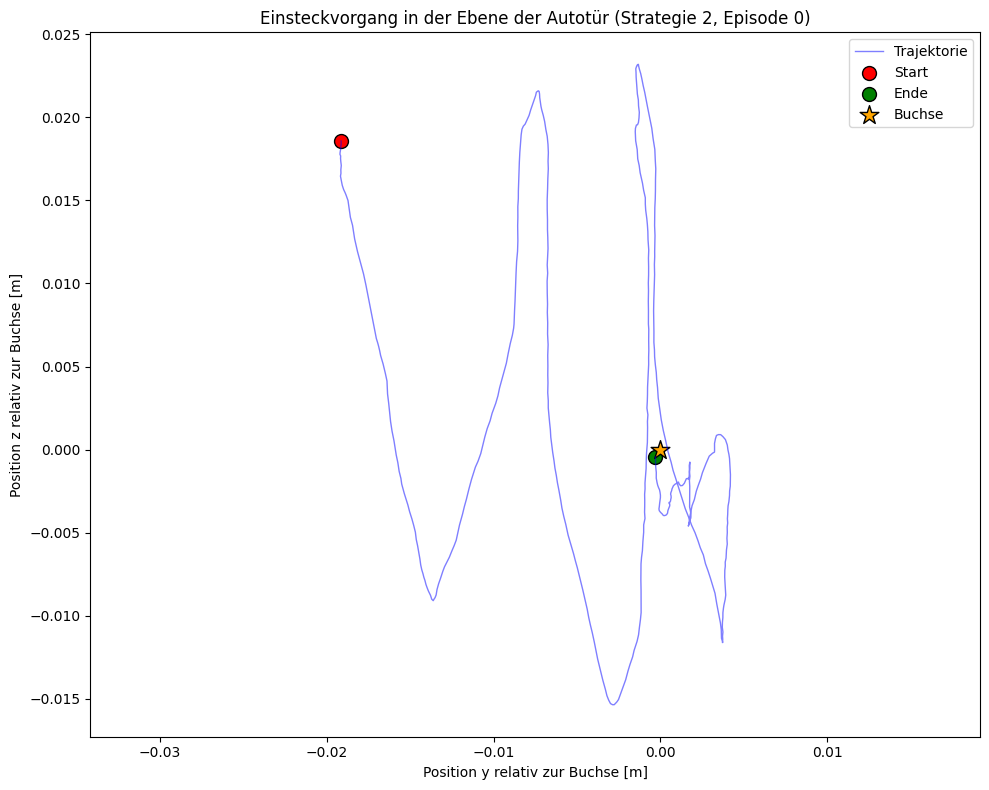

In [8]:
#Plotten des Einsteckvorgangs in y-z-Ebene

# Position der Buchse in Metern
position_y = 0.14
position_z = 0.55  

# Positionen relativ zur Buchse berechnen
y_rel = df_filled['current_absolute_pose_y'] - position_y
z_rel = df_filled['current_absolute_pose_z'] - position_z

plt.figure(figsize=(10, 8))

# Trajektorie plotten
plt.plot(y_rel, z_rel, 'b-', alpha=0.5, linewidth=1, label='Trajektorie')

# Startpunkt (rot)
plt.scatter(y_rel.iloc[0], z_rel.iloc[0], c='red', s=100, marker='o', 
            label='Start', edgecolors='black')

# Endpunkt (grün)
plt.scatter(y_rel.iloc[-1], z_rel.iloc[-1], c='green', s=100, marker='o', 
            label='Ende', edgecolors='black')

# Mittelpunkt der Buchse
plt.scatter(0, 0, c='orange', s=200, marker='*', 
            label='Buchse', edgecolors='black')

plt.xlabel('Position y relativ zur Buchse [m]')
plt.ylabel('Position z relativ zur Buchse [m]')
plt.title('Einsteckvorgang in der Ebene der Autotür (Strategie 2, Episode 0)')
plt.legend()
plt.axis('equal') #Gleiche Skalierung für x- und y-Achse, damit die Achsen nicht verzerrt werden
plt.tight_layout()
plt.show()



### 2.2.4 Beschreiben der Suchstrategie

Es gibt 2 Hauptbewegungen: Der Demonstrator fährt erst global im Zickzack zum Stecker hin und versucht dann lokal den Stecker einzustecken. Wobei auch Rotation und Neigung des Steckers sichergestellt werden muss.

In [9]:
list_strategy = ['strategy_0', 'strategy_1', 'strategy_2', 'strategy_3']
episodes_dict = {}
values_dict = {}

#Einlesen der Episode 0 aller Strategien
for strategy in list_strategy:
    episode_path = f'data_v2/data_search_strategy/{strategy}/episode_0.csv' #Pfad zur Episode der aktuellen Strategie
    episodes_dict[strategy] = pd.read_csv(episode_path, sep=';',decimal=",").interpolate().ffill().bfill() #Fehlende Werte auffüllen wie oben
    values_dict[strategy] = (gamma ** np.arange(len(episodes_dict[strategy])) * episodes_dict[strategy]['reward'].values).sum() #Value der Episode berechnen und speichern
    print(f'Wert V^pi(s) von {strategy}: {values_dict[strategy]:.4f}')
    

Wert V^pi(s) von strategy_0: 0.6722
Wert V^pi(s) von strategy_1: 0.0000
Wert V^pi(s) von strategy_2: 0.5849
Wert V^pi(s) von strategy_3: 0.8360


In [10]:
#Sortieren der Strategien nach ihrem Value
sorted_strategies = sorted(values_dict, key=values_dict.get, reverse=True)
print("Strategien sortiert nach ihrem Value (höchster zuerst):")
for strategy in sorted_strategies:
    print(f'{strategy}')

Strategien sortiert nach ihrem Value (höchster zuerst):
strategy_3
strategy_0
strategy_2
strategy_1


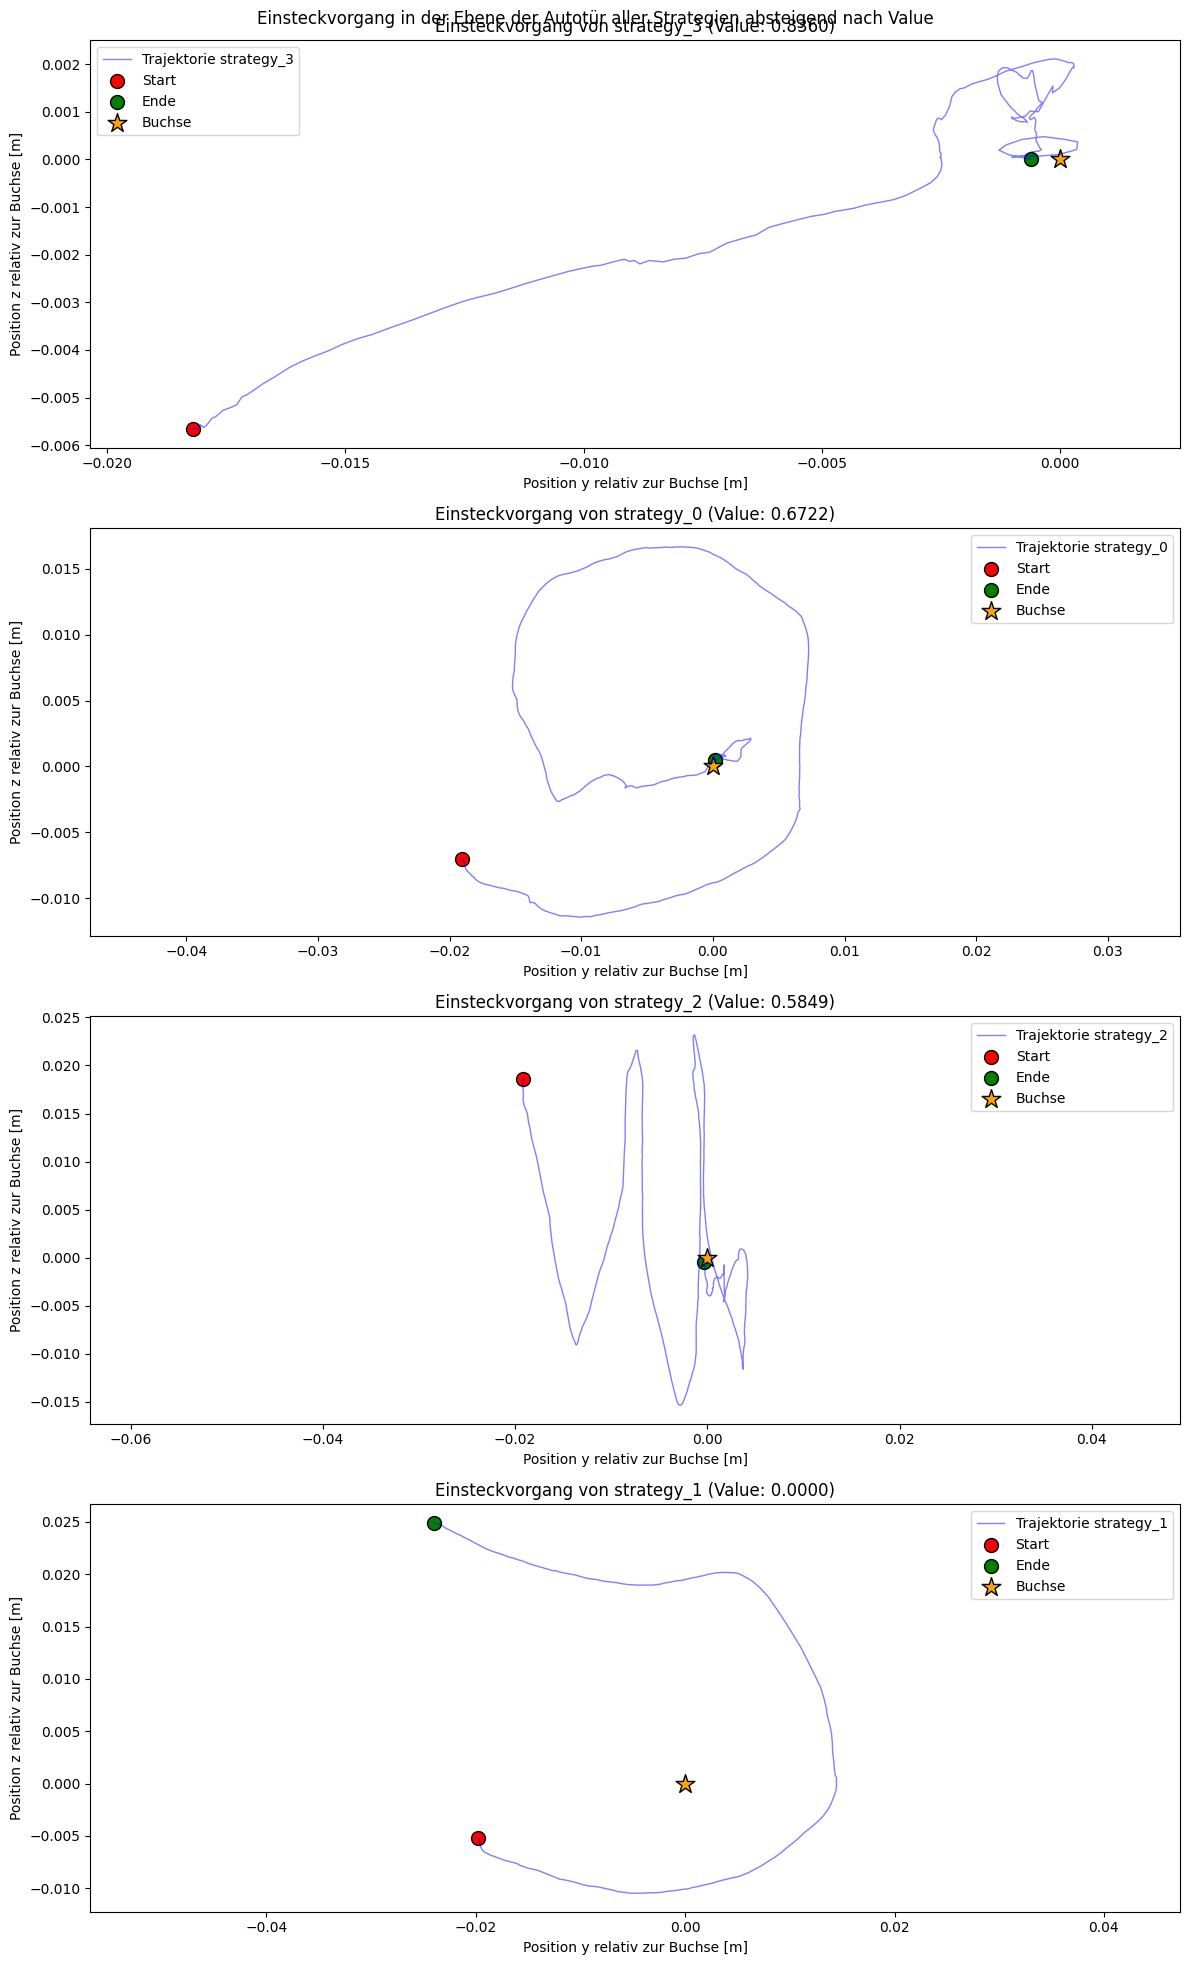

In [11]:
#Plotten alle Strategien in 2D für die y-z-Ebene
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
fig.suptitle('Einsteckvorgang in der Ebene der Autotür aller Strategien absteigend nach Value')

#Schleife über die Strategien und Plotten der Trajektorien
for i, strategy in enumerate(sorted_strategies):
    df_strategy = episodes_dict[strategy]
    position_y = 0.14
    position_z = 0.55  
    y_rel = df_strategy['current_absolute_pose_y'] - position_y
    z_rel = df_strategy['current_absolute_pose_z'] - position_z

    axes[i].set_aspect('equal', adjustable='datalim') #Gleiche Skalierung für y- und z-Achse, damit die Achsen nicht verzerrt werden
    
    axes[i].plot(y_rel, z_rel, 'b-', alpha=0.5, linewidth=1, label=f'Trajektorie {strategy}')
    axes[i].scatter(y_rel.iloc[0], z_rel.iloc[0], c='red', s=100, marker='o', 
                    label='Start', edgecolors='black')
    axes[i].scatter(y_rel.iloc[-1], z_rel.iloc[-1], c='green', s=100, marker='o', 
                    label='Ende', edgecolors='black')
    axes[i].scatter(0, 0, c='orange', s=200, marker='*', 
                    label='Buchse', edgecolors='black')
    axes[i].set_xlabel('Position y relativ zur Buchse [m]')
    axes[i].set_ylabel('Position z relativ zur Buchse [m]')
    axes[i].set_title(f'Einsteckvorgang von {strategy} (Value: {values_dict[strategy]:.4f})')
    axes[i].legend()


plt.tight_layout()
plt.show()


### 2.2.7 Beschreibung der Suchstrategie

- 1 (strategie_3): Globales Annähern des Steckers von einer Seite, gefolgt von lokalem Kreisen um den Buchsenmittelpunkt. Dabei ist auch gezittertes Verhalten zu beobachten, vermutlich um Rotation und Neigung des Steckers zu korrigieren. Diese Strategie erreicht den höchsten Value.

- 2 (strategie_0): Globales Kreisen um den Buchsenmittelpunkt, um die genaue Position zu finden, gefolgt von lokalem gezittertem Verhalten zum Einstecken. Erreicht einen Value von 0.67.

- 3 (strategie_2): Globale Zickzack-Bewegung zur Annäherung, gefolgt von einer lokalen Zickzack-Bewegung zum Einstecken. Erreicht einen Value von 0.58.

- 4 (strategie_1): Kreisbewegung um den Buchsenmittelpunkt ohne zunehmende Annäherung – der Kreis wird nicht enger. Dadurch wird der Stecker nie eingesteckt, was zu einem Value von 0 führt


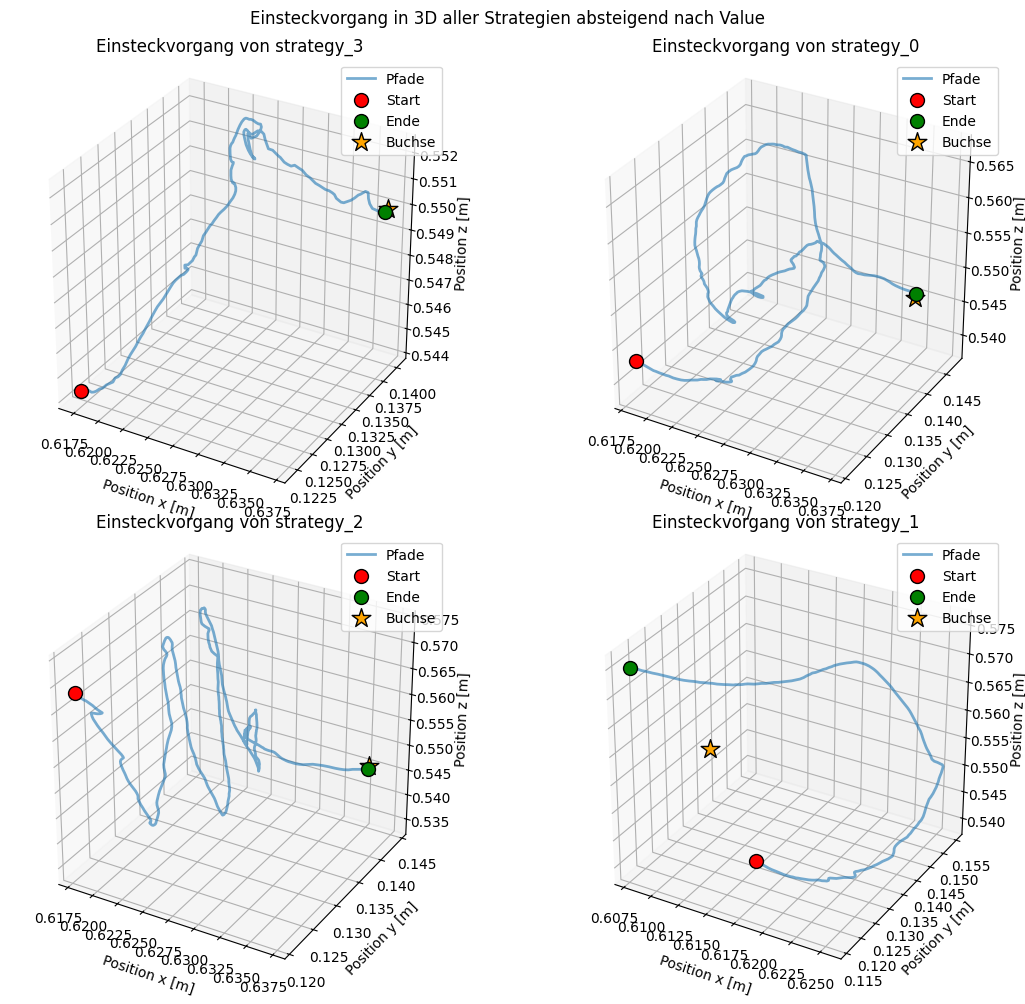

In [12]:
#Plotten aller Strategien in 3D
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Einsteckvorgang in 3D aller Strategien absteigend nach Value')

for i, strategy in enumerate(sorted_strategies):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    df_strategy = episodes_dict[strategy]

    #Position der Buchse in Metern
    position_y = 0.14
    position_z = 0.55

    #Absolute Positionen
    x_rel_2 = df_strategy['current_absolute_pose_x']
    y_rel_2 = df_strategy['current_absolute_pose_y']
    z_rel_2 = df_strategy['current_absolute_pose_z']

    ax.set_box_aspect([1,1,1]) #Gleiche Skalierung für alle Achsen

    #Trajektorie
    ax.plot(x_rel_2, y_rel_2, z_rel_2, alpha=0.6, linewidth=2, label='Pfade')
    
    #Start
    ax.scatter(x_rel_2.iloc[0], y_rel_2.iloc[0], z_rel_2.iloc[0], c='red', s=100, 
              marker='o', label='Start', edgecolors='black')
    
    #Ende
    ax.scatter(x_rel_2.iloc[-1], y_rel_2.iloc[-1], z_rel_2.iloc[-1], c='green', s=100, 
              marker='o', label='Ende', edgecolors='black')
    
    #Buchse
    ax.scatter(x_rel_2.iloc[-1], position_y, position_z, c='orange', s=200, 
              marker='*', label='Buchse', edgecolors='black')
    
    ax.set_xlabel('Position x [m]')
    ax.set_ylabel('Position y [m]')
    ax.set_zlabel('Position z [m]')
    ax.set_title(f'Einsteckvorgang von {strategy}')
    ax.legend()

plt.tight_layout()
plt.show()

    

Im 3D-Plot ist zusätzlich die Bewegung in x-Richtung sichtbar. Man erkennt, dass sich der Stecker während der Suche kontinuierlich in Richtung der Buchse bewegt, das war im 2D y-z-Plot noch nicht erkennbar.